In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("/kaggle/input/common-voice/cv-valid-train.csv")

In [3]:
df = df[['filename','gender']]

In [4]:
df.dropna(inplace=True)

In [5]:
index = df[(df['gender'] == 'male')].index
i = index[::2]
df.drop(i, inplace=True)
index = df[(df['gender'] == 'male')].index
i = index[::4]
df.drop(i, inplace=True)
index = df[(df['gender'] == 'other')].index
df.drop(index, inplace=True)

In [6]:
df.reset_index(inplace=True)
df = df[['filename','gender']]
df

,filename,gender
0,cv-valid-train/sample-000005.mp3,female
1,cv-valid-train/sample-000013.mp3,female
2,cv-valid-train/sample-000020.mp3,male
3,cv-valid-train/sample-000026.mp3,female
4,cv-valid-train/sample-000027.mp3,male
...,...,...
38879,cv-valid-train/sample-195758.mp3,female
38880,cv-valid-train/sample-195760.mp3,male
38881,cv-valid-train/sample-195765.mp3,female
38882,cv-valid-train/sample-195767.mp3,female


In [7]:
gender = np.array(df['gender'])

In [8]:
val, count = np.unique(gender, return_counts=True)

In [9]:
val,count

(array(['female', 'male'], dtype=object), array([18249, 20635]))

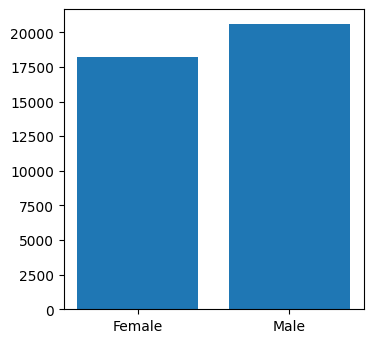

In [10]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_axes([0,0,1,1])
gen = ["Female", "Male"]
values = np.array(count)
ax.bar(gen, values)
plt.show()

In [11]:
import librosa

In [12]:
index = df[(df['gender'] == 'male')].index
filename = "/kaggle/input/common-voice/cv-valid-train/"+df['filename'][index[100]]
m, sr1 = librosa.load(filename, sr=None) 
index = df[(df['gender'] == 'female')].index
filename = "/kaggle/input/common-voice/cv-valid-train/"+df['filename'][index[100]]
f, sr2 = librosa.load(filename, sr=None) 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
m.shape,f.shape

((156672,), (139392,))

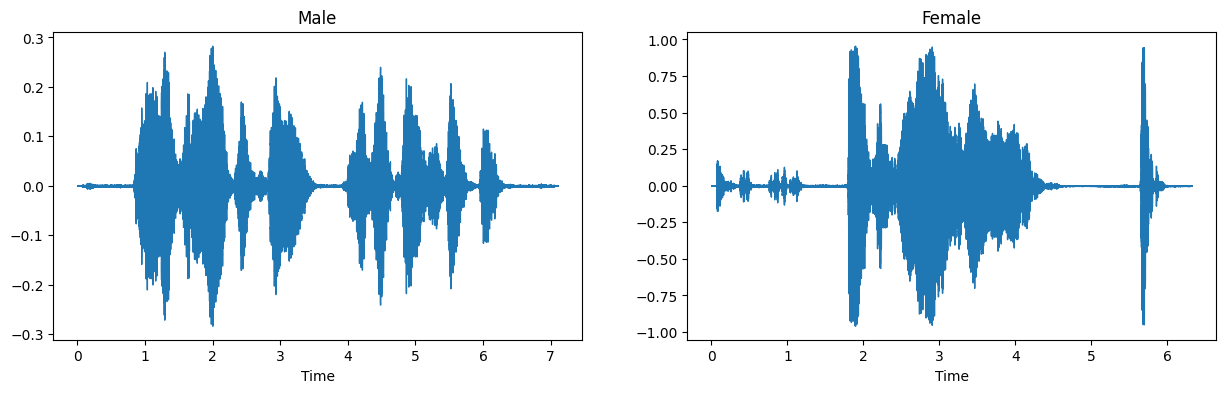

In [14]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
librosa.display.waveshow(m)
plt.title("Male")
plt.subplot(1,2,2)
librosa.display.waveshow(f)
plt.title("Female")
plt.show()

In [15]:
md = librosa.stft(m)
m_db = librosa.amplitude_to_db(np.abs(md), ref=np.max)
fd = librosa.stft(f)
f_db = librosa.amplitude_to_db(np.abs(fd), ref=np.max)

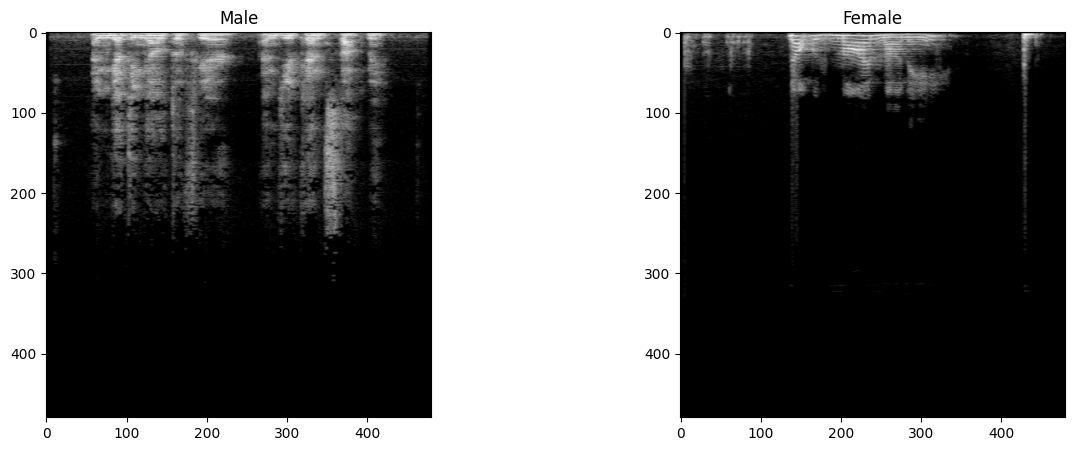

In [16]:
import cv2
im1 = cv2.resize(m_db,(480,480))
im2 = cv2.resize(f_db,(480,480))
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(im1, cmap=plt.cm.gray)
plt.title("Male")
plt.subplot(1,2,2)
plt.imshow(im2, cmap=plt.cm.gray)
plt.title("Female")
plt.show()

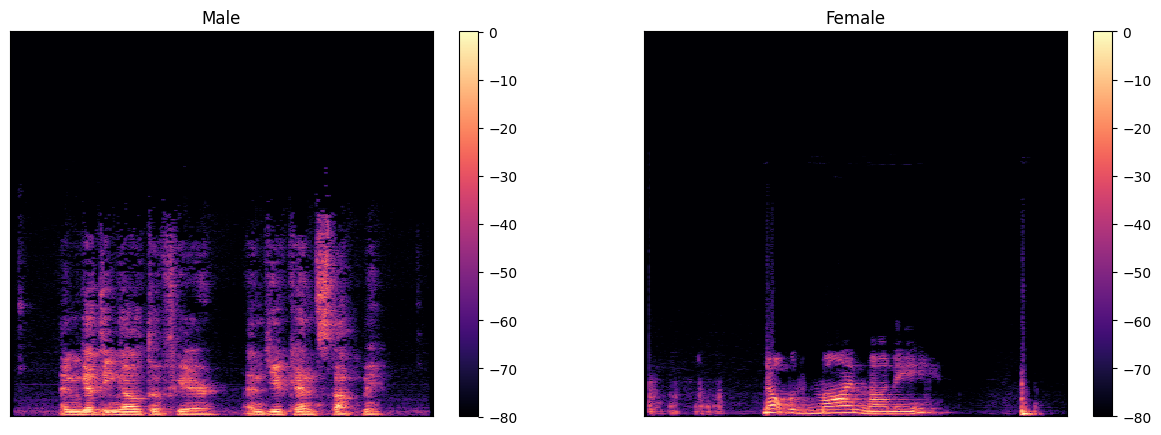

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
librosa.display.specshow(m_db)
plt.colorbar()
plt.title("Male")
plt.subplot(1,2,2)
librosa.display.specshow(f_db)
plt.colorbar()
plt.title("Female")
plt.show()

In [18]:
s1 = np.abs(librosa.stft(m)**2)
chroma_m = librosa.feature.chroma_stft(S=s1, sr=sr1)

In [19]:
s2 = np.abs(librosa.stft(f)**2)
chroma_f = librosa.feature.chroma_stft(S=s2, sr=sr2)

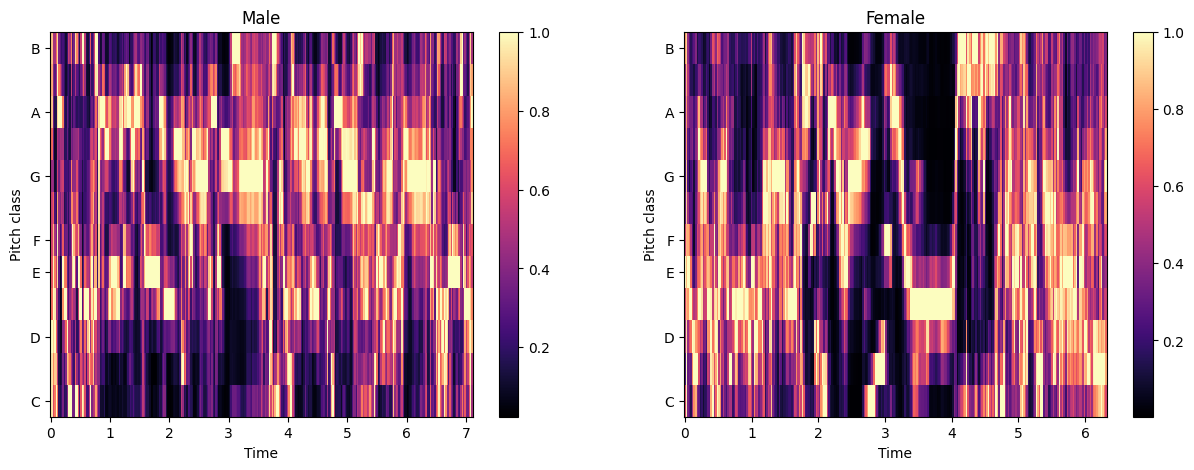

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
img = librosa.display.specshow(chroma_m, y_axis='chroma', x_axis='time')
plt.title("Male")
plt.colorbar(img)
plt.subplot(1,2,2)
img = librosa.display.specshow(chroma_f, y_axis='chroma', x_axis='time')
plt.title("Female")
plt.colorbar(img)
plt.show()

In [21]:
chroma = np.cumsum(chroma_f)
chroma

array([5.8710366e-01, 1.5586660e+00, 1.9077771e+00, ..., 1.4862808e+03,
       1.4866116e+03, 1.4869873e+03], dtype=float32)

In [22]:
chroma.shape,chroma_f.shape,chroma_m.shape

((3276,), (12, 273), (12, 307))

In [23]:
images = []
labels = []

In [24]:
gen = ['male','female']

In [25]:
for i in range(len(df['filename'])):
    filename = "/kaggle/input/common-voice/cv-valid-train/"+df['filename'][i]
    y, sr = librosa.load(filename, sr=None) 
    d = librosa.stft(y)
    db = librosa.amplitude_to_db(np.abs(d), ref=np.max)
    db = cv2.resize(db,(64,64))
    db = (db+80)/80
    images.append(db)
    labels.append(gen.index(df['gender'][i]))

In [26]:
images = np.array(images)
labels = np.array(labels)

In [27]:
np.save('images.npy',images)
np.save('labels.npy',labels)

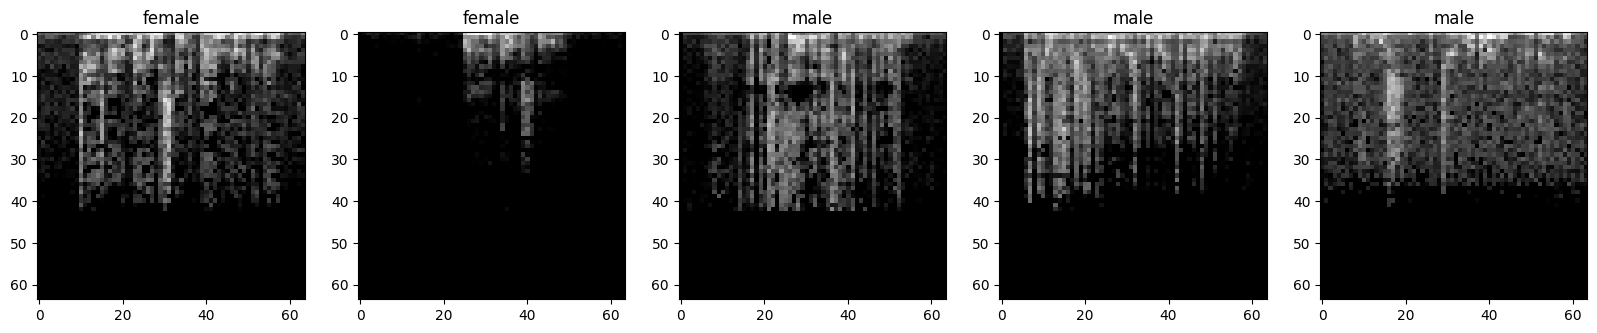

In [28]:
plt.figure(figsize=(20,20))
for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(images[3*i*i], cmap=plt.cm.gray)
    plt.title(gen[labels[3*i*i]])
plt.show()

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
x_train,x_test,y_train,y_test = train_test_split(images,labels,test_size=0.2, stratify=labels, shuffle=True)

In [31]:
x_val,x_test,y_val,y_test = train_test_split(x_test,y_test,test_size=0.5)

In [32]:
x_train.shape,x_test.shape,x_val.shape

((31107, 64, 64), (3889, 64, 64), (3888, 64, 64))

In [33]:
from tensorflow import keras
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from keras.models import Sequential
from keras.optimizers import Adam

In [34]:
model = Sequential()
model.add(Conv2D(128, 3, activation='relu', input_shape=(64,64,1)))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(256, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(512, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(1024, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(1, activation='sigmoid'))

In [35]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 128)       1280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 256)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 256)       0

In [36]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
file_s = "Voice_Gender_Detector.h5"
checkpoint = ModelCheckpoint(file_s, monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=False, mode="auto", freq="epoch")
Early_stop = EarlyStopping(patience=50, monitor="val_loss", restore_best_weights=True)
callback_list = [checkpoint,Early_stop]

In [37]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=64, epochs=150, callbacks=[callback_list])

Epoch 1/150


2023-12-20 08:48:39.883343: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


487/487 [==============================] - ETA: 0s - loss: 0.6635 - accuracy: 0.5823
Epoch 1: val_loss improved from inf to 0.64717, saving model to Voice_Gender_Detector.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


487/487 [==============================] - 27s 32ms/step - loss: 0.6635 - accuracy: 0.5823 - val_loss: 0.6472 - val_accuracy: 0.6572
Epoch 2/150
485/487 [============================>.] - ETA: 0s - loss: 0.4558 - accuracy: 0.7888
Epoch 2: val_loss improved from 0.64717 to 0.31710, saving model to Voice_Gender_Detector.h5
487/487 [==============================] - 15s 31ms/step - loss: 0.4617 - accuracy: 0.7887 - val_loss: 0.3171 - val_accuracy: 0.8663
Epoch 3/150
485/487 [============================>.] - ETA: 0s - loss: 0.3699 - accuracy: 0.8408
Epoch 3: val_loss improved from 0.31710 to 0.27788, saving model to Voice_Gender_Detector.h5
487/487 [==============================] - 15s 30ms/step - loss: 0.3881 - accuracy: 0.8407 - val_loss: 0.2779 - val_accuracy: 0.8902
Epoch 4/150
485/487 [============================>.] - ETA: 0s - loss: 0.3455 - accuracy: 0.8528
Epoch 4: val_loss improved from 0.27788 to 0.25701, saving model to Voice_Gender_Detector.h5
487/487 [======================

In [38]:
model.evaluate(x_test, y_test)

122/122 [==============================] - 1s 7ms/step - loss: 15.5042 - accuracy: 0.9090


[15.504199981689453, 0.9089740514755249]

In [39]:
pred = model.predict(x_test)

122/122 [==============================] - 1s 4ms/step


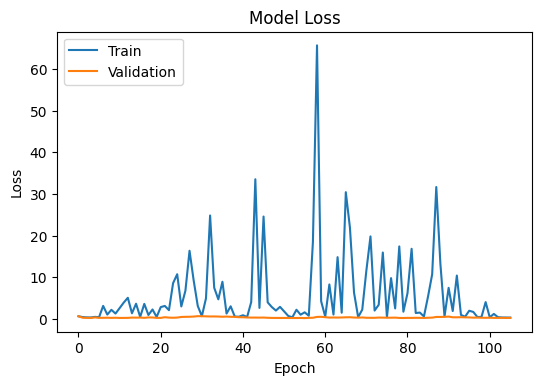

In [40]:
plt.figure(figsize=(5,3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper left")
plt.subplots_adjust(left=0, bottom=0, top=1, right=0.95, wspace=0.35, hspace=0.25)

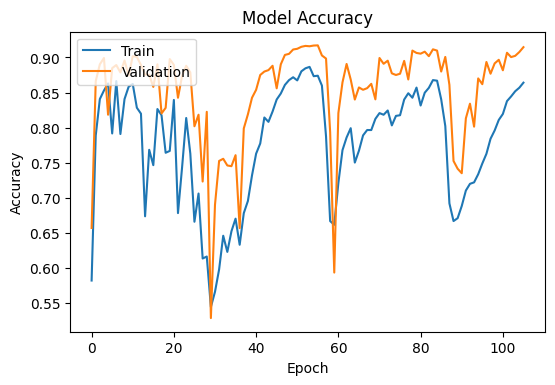

In [41]:
plt.figure(figsize=(5,3))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.subplots_adjust(left=0, bottom=0, top=1, right=0.95, wspace=0.35, hspace=0.25)

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [43]:
pred_l = []
for i in pred:
    if i[0]>0.5:
        pred_l.append(1)
    else:
        pred_l.append(0)
pred = np.array(pred_l)

In [44]:
result = confusion_matrix(y_test, pred)
print(result)

[[1940  132]
 [ 222 1595]]


In [45]:
report = classification_report(y_test, pred)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2072
           1       0.92      0.88      0.90      1817

    accuracy                           0.91      3889
   macro avg       0.91      0.91      0.91      3889
weighted avg       0.91      0.91      0.91      3889



<Axes: >

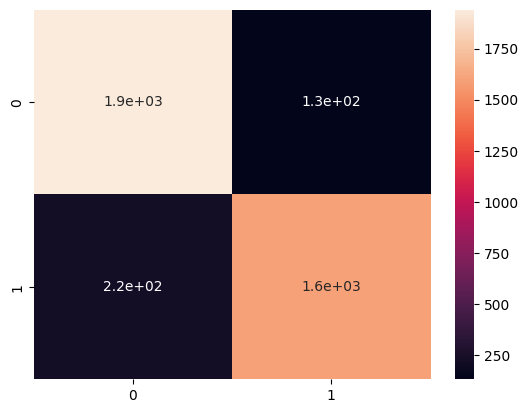

In [46]:
import seaborn as sns
sns.heatmap(result,annot=True)

122/122 [==============================] - 1s 4ms/step


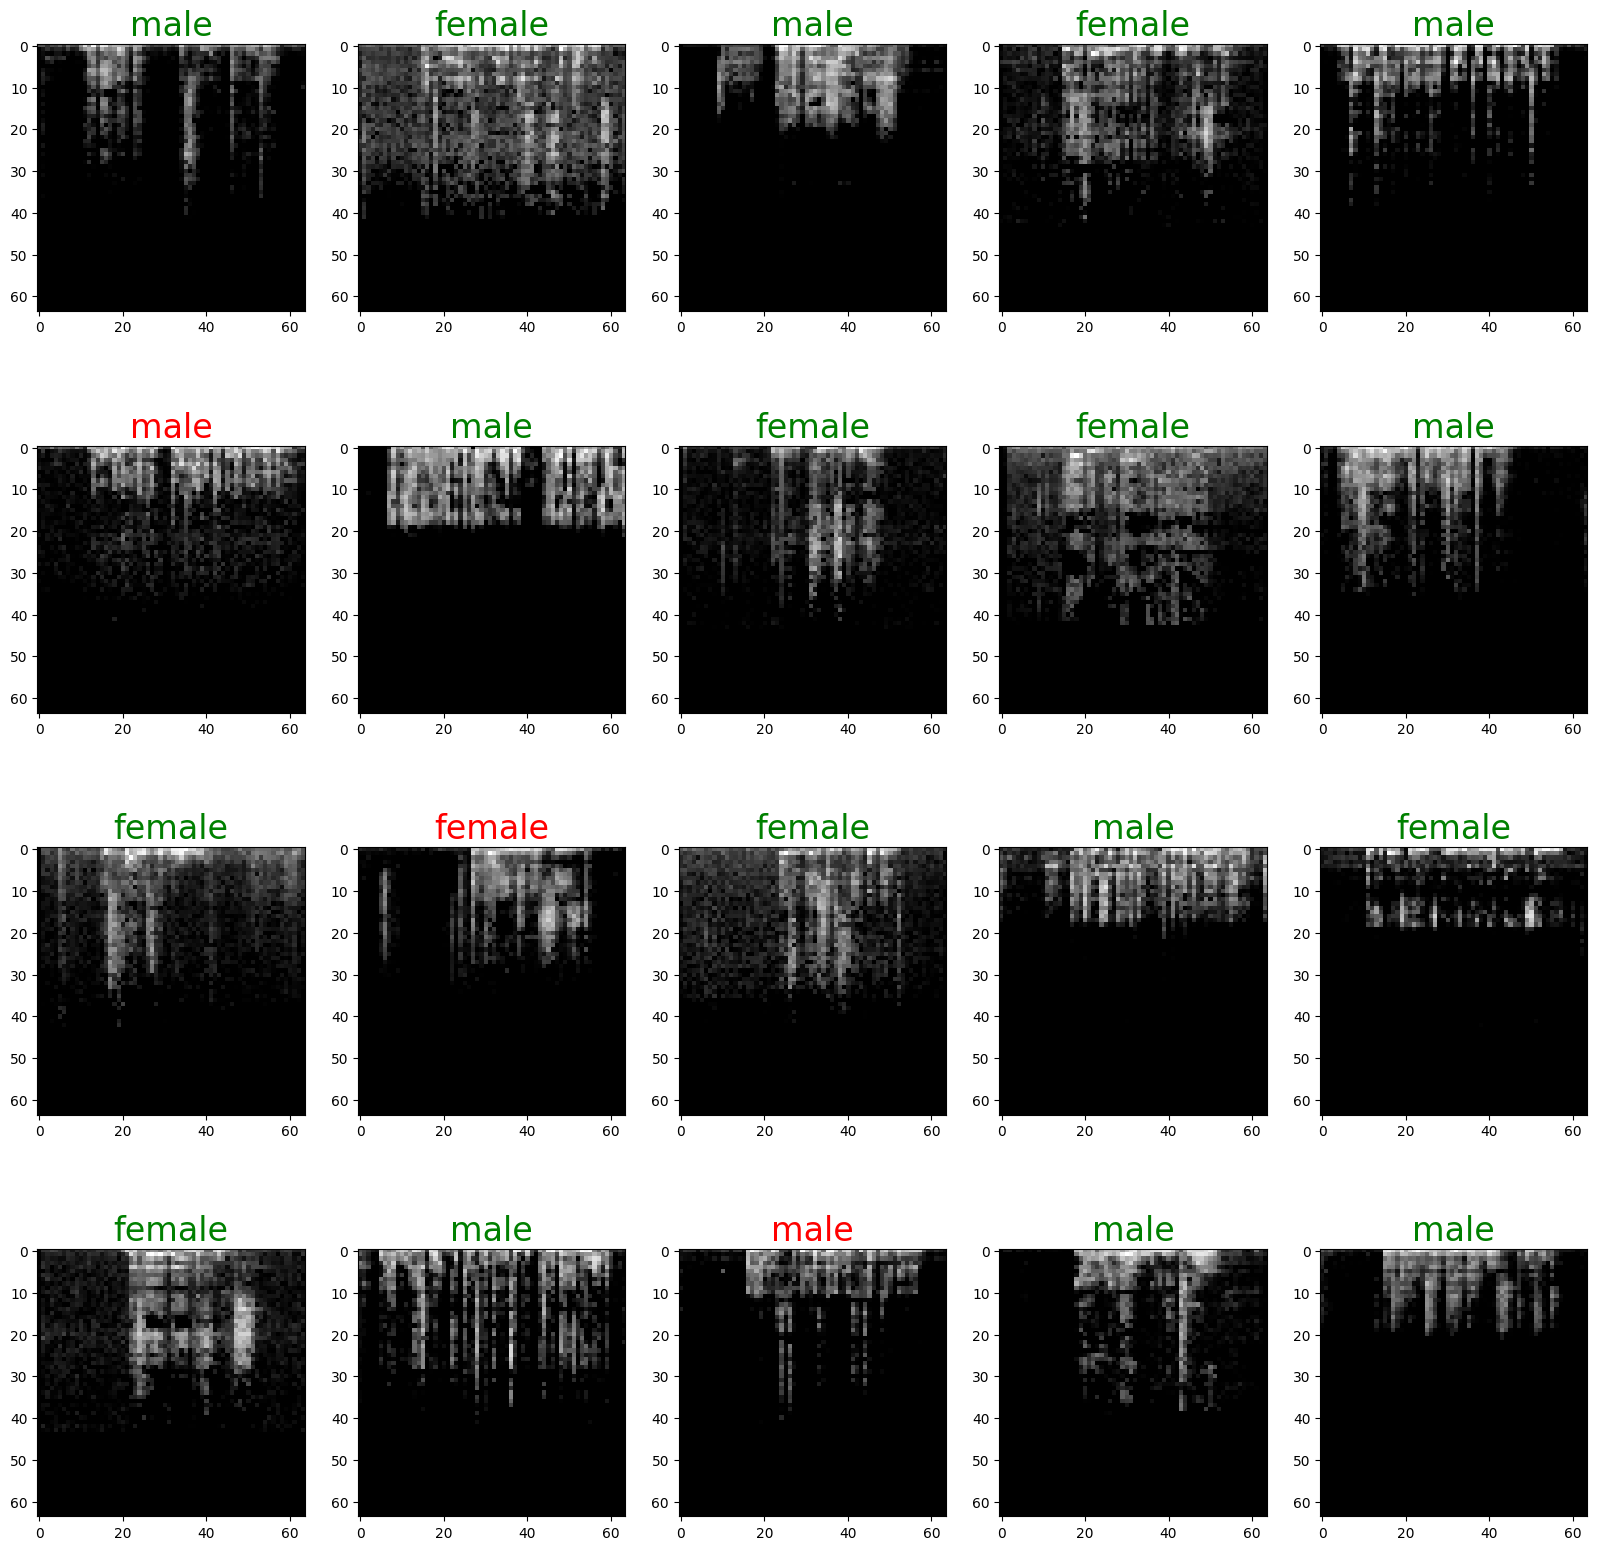

In [47]:
plt.figure(figsize=(20,20))
e = model.predict(x_test)
for i in range(11,31):
    plt.subplot(4,5,i-10)
    plt.imshow(x_test[i], cmap=plt.cm.gray)
    p = 1 if e[i][0]>0.5 else 0
    plt.title(gen[p],fontsize=24, color='green' if p==y_test[i] else 'red')
plt.show()